In [1]:
import pandas as pd
import numpy as np
import csv

In [2]:
filteredGeneList = pd.read_csv('filteredGenesDetails_human_240118.txt',sep='\t')
filteredGeneList.head(2)

,GeneName,AccNum,Chrom,mRNALength,ORFLength,fpUTR_length,tpUTR_length,sumIntronLengths
0,UBE2Q1,NM_017582,chr1,3223,1269,91,1863,6847
1,DUOXA1,NM_001276267,chr15,3032,897,395,1740,9479


In [3]:
acc2gene={}
for idx,row in filteredGeneList.iterrows():
    acc2gene[row['AccNum']] = row['GeneName']
acc2gene['NM_017582']

'UBE2Q1'

In [4]:
def get_fa(filename,onlyKeys = 'All'):
    keyD = dict()
    if onlyKeys!='All':
        for k in onlyKeys: keyD[k] = None
        
    def addEntry(current,d):
        entry = current.split('\n')
        if entry[0]!='' and (onlyKeys=='All' or keyD.has_key(entry[0])):
            d[entry[0]] = ''.join(entry[1:])

    d = dict()
    bf = open(filename)
    current = ['\n']
    for line in bf:
        if line[0]=='>':
            addEntry(''.join(current),d)
            if len(line)>1: current = [line[1:]]
            else: current = ['\n']
        else: current.append(line)
    addEntry(''.join(current),d)
    bf.close()
    return d

In [5]:
splicedGenes = get_fa('splicedGenes_240118.txt')
print(type(splicedGenes))
print(list(splicedGenes.keys())[0:3])

<class 'dict'>
['NR_148357_chr1(+):11868-14361', 'NR_046018_chr1(+):11873-14408', 'NR_024540_chr1(-):14361-29369']


In [6]:
## truncate the keys to only accNum
ks = list(splicedGenes.keys())
for key in ks:
    splicedGenes[key.split('_chr')[0]] = splicedGenes[key]
    splicedGenes.pop(key)
print(type(splicedGenes))
print(list(splicedGenes.keys())[0:3])

<class 'dict'>
['NR_148357', 'NR_046018', 'NR_024540']


In [8]:
splicedORFs = get_fa('splicedORFs_240118.txt')
print(type(splicedORFs))
print(list(splicedORFs.keys())[0:3])

<class 'dict'>
['NM_017582', 'NM_001276267', 'NM_173469']


In [9]:
fpUTR={}
tpUTR = {}
ORFs = {}
for idx,row in filteredGeneList.iterrows():
    accNum = row['AccNum']
    fpLen = row['fpUTR_length']
    tpLen = row['tpUTR_length']
    fpUTR[accNum] = splicedGenes[accNum][0:fpLen]
    tpUTR[accNum] = splicedGenes[accNum][-tpLen:]
    ORFs[accNum] = splicedORFs[accNum]

In [12]:
L24_t1 = pd.read_csv('../Deseq2 Analysis/shift15/coding/csv_raw/ER_S15_t1.csv')
filteredList = L24_t1[L24_t1['padj'] < 0.05]
print('pass filter:' ,len(filteredList))

filteredList = filteredList.sort_values(by=['log2FoldChange'])
topNum=sum((filteredList['log2FoldChange']>1)*1)
print('up num: ',topNum)
botNum=sum((filteredList['log2FoldChange']<-1)*1)
print('down num: ',botNum)
filteredList.tail()

pass filter: 1271
up num:  189
down num:  15


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
4546,NM_033625,148.300200,1.948511,0.515919,3.776773,1.588733e-04,2.904801e-03
5235,NM_006014,309.912400,2.084840,0.285811,7.294476,2.998229e-13,1.394083e-10
5530,NM_004965,261.013700,2.211505,0.164584,13.436970,3.671431e-41,2.933473e-37
689,NM_000992,359.205401,2.322047,0.334887,6.933830,4.095955e-12,1.422899e-09
1719,NM_000421,365.155577,3.083594,0.363617,8.480346,2.245253e-17,2.562796e-14


In [23]:
downAccs = filteredList.loc[filteredList['log2FoldChange']<-1]['Unnamed: 0']
upAccs = filteredList.loc[filteredList['log2FoldChange']>1]['Unnamed: 0']
midAccs = filteredList.loc[(filteredList['log2FoldChange']>= -1) & (filteredList['log2FoldChange']<= 1)]['Unnamed: 0']

In [82]:
## not so good, Try again
filteredGeneList['logFC'] = None
filteredGeneList['noChange'] = None
filteredGeneList.loc[filteredGeneList['AccNum'].isin(downAccs),'logFC'] = 'Up'
filteredGeneList.loc[filteredGeneList['AccNum'].isin(upAccs),'logFC'] = 'Down'
filteredGeneList.loc[filteredGeneList['AccNum'].isin(midAccs),'noChange'] = 'noChange'
filteredGeneList.head()

,GeneName,AccNum,Chrom,mRNALength,ORFLength,fpUTR_length,tpUTR_length,sumIntronLengths,logFC,noChange
0,UBE2Q1,NM_017582,chr1,3223,1269,91,1863,6847,None,None
1,DUOXA1,NM_001276267,chr15,3032,897,395,1740,9479,None,None
2,UBE2Q2,NM_173469,chr15,3098,1128,381,1589,54664,None,None
3,RNF10,NM_001330474,chr12,3861,2451,482,928,39404,None,None
4,RNF11,NM_014372,chr1,3074,465,484,2125,34101,None,None


In [83]:
import seaborn as sns

Text(0.5, 1.0, 'L24')

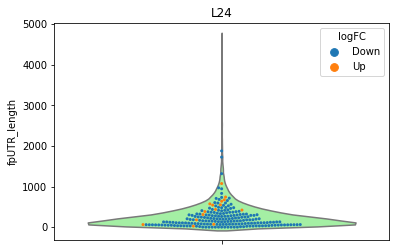

In [96]:
dat=filteredGeneList.loc[~filteredGeneList['logFC'].isna()]
ax = sns.violinplot( y='fpUTR_length', data=filteredGeneList, inner=None,color='palegreen')
ax = sns.swarmplot(x=[""]*len(dat),y = dat['fpUTR_length'],hue = dat['logFC'],
    size=3);
ax.set_title('L24')

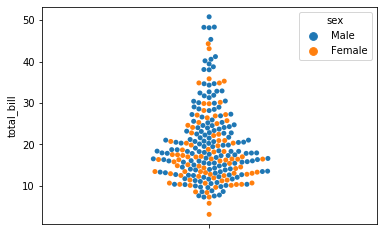

In [89]:
import matplotlib.pyplot as plt
tips = sns.load_dataset("tips")
sns.swarmplot(x=[""]*len(tips),y="total_bill", hue="sex", data=tips)
plt.show()